<h2>Problem Statement</h2>

<b>Can we predict if a loan is likely to be paid back, and if so, what factors influnce the likelihood of being paid back?</b><br>
In other words, can we predict if a loan going to be defaulted, and what factors influence if a loan is prone to defaulting?

<h2>EDA</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('playground-series-s4e10/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
# Renaming columns for easier understanding - looked at Kaggle notebooks for definitions on some variables
df = df.rename(columns={'cb_person_default_on_file': 'history_of_default',
                        'cb_person_cred_hist_length': 'cred_hist_length'})
df.head() # Confirming changes

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
print(f"Shape of data: {df.shape}\n")
print(df.info())

Shape of data: (58645, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     58645 non-null  int64  
 1   person_age             58645 non-null  int64  
 2   person_income          58645 non-null  int64  
 3   person_home_ownership  58645 non-null  object 
 4   person_emp_length      58645 non-null  float64
 5   loan_intent            58645 non-null  object 
 6   loan_grade             58645 non-null  object 
 7   loan_amnt              58645 non-null  int64  
 8   loan_int_rate          58645 non-null  float64
 9   loan_percent_income    58645 non-null  float64
 10  history_of_default     58645 non-null  object 
 11  cred_hist_length       58645 non-null  int64  
 12  loan_status            58645 non-null  int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 5.8+ MB
None


In [5]:
print(f"Unique values:\n {df.nunique()}\n")
print(f"Null values:\n {df.isnull().sum()}")

Unique values:
 id                       58645
person_age                  53
person_income             2641
person_home_ownership        4
person_emp_length           36
loan_intent                  6
loan_grade                   7
loan_amnt                  545
loan_int_rate              362
loan_percent_income         61
history_of_default           2
cred_hist_length            29
loan_status                  2
dtype: int64

Null values:
 id                       0
person_age               0
person_income            0
person_home_ownership    0
person_emp_length        0
loan_intent              0
loan_grade               0
loan_amnt                0
loan_int_rate            0
loan_percent_income      0
history_of_default       0
cred_hist_length         0
loan_status              0
dtype: int64


In [6]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


I noticed that person_age and person_emp_length have extremely high maximums that are unreasonable (at 123 years), so we'll check our variables out through histograms to see the distribution.

person_income also has an extremely high maximum, so we'll also use a histogram to see the distribution of the data.

I'm also going to drop id from our data, as it provides no value for analysis.

In [7]:
df = df.drop(['id'], axis = 1)

In [8]:
# Separating numerical and categorical variables for analysis
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=np.number).columns.tolist()

print(f"Categorical Variables: {cat_features}")
print(f"Numerical Variables: {num_features}")

Categorical Variables: Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'history_of_default'],
      dtype='object')
Numerical Variables: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cred_hist_length', 'loan_status']


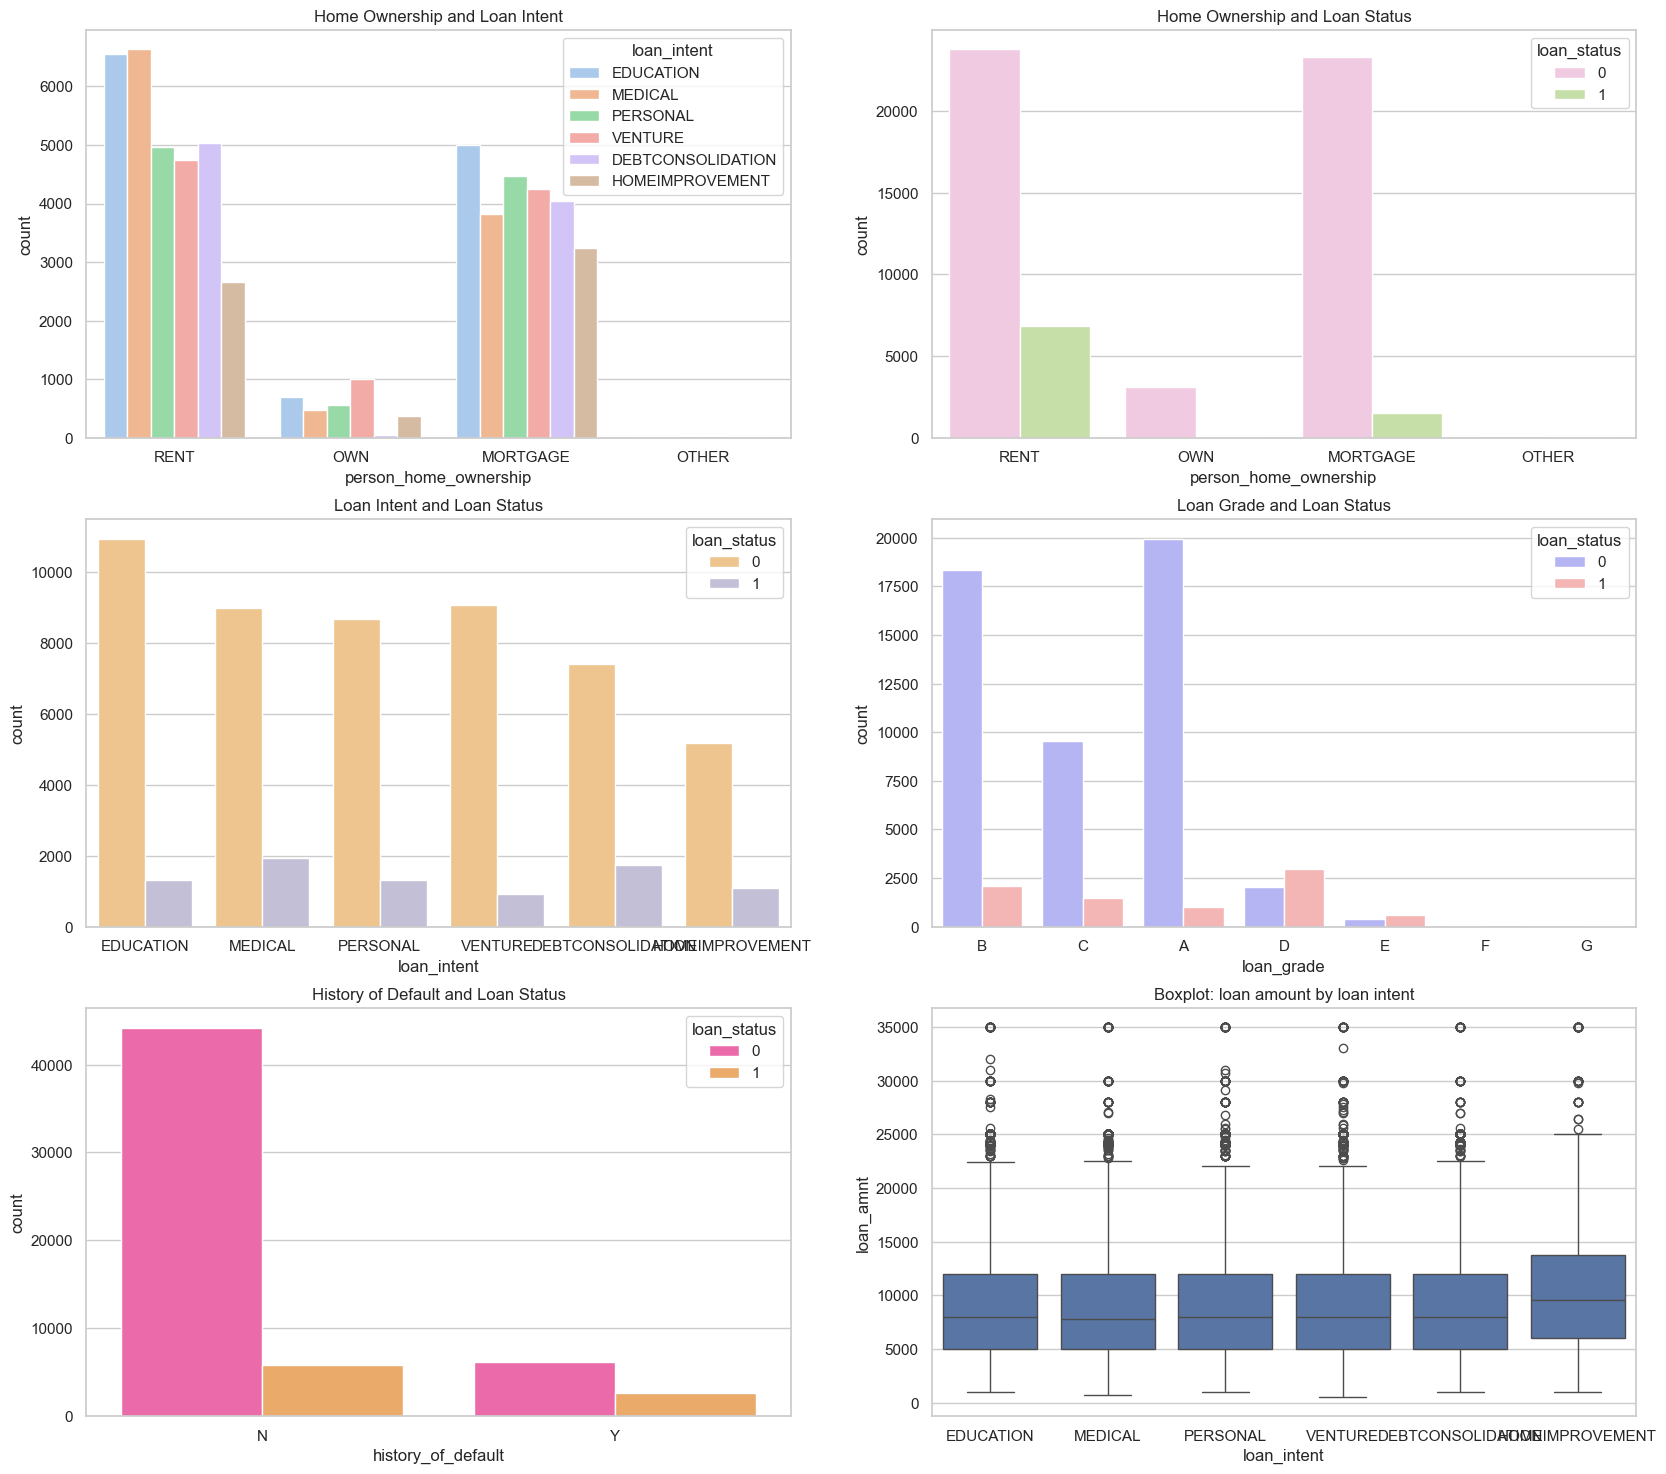

In [9]:
# Grouped bar plot for categorical vs. categorical
# Also playing around with palettes lol

fig, ax = plt.subplots(3, 2, figsize=(20, 18))

# Home Ownership and Loan Intent
sns.countplot(data=df, x='person_home_ownership', hue='loan_intent', palette='pastel', ax=ax[0,0])
ax[0,0].set_title("Home Ownership and Loan Intent")

# Home Ownership and Loan Status
sns.countplot(data=df, x='person_home_ownership', hue='loan_status', palette='PiYG', ax=ax[0,1])
ax[0,1].set_title("Home Ownership and Loan Status")

# Loan Intent and Loan Status
sns.countplot(data=df, x='loan_intent', hue='loan_status', palette='PuOr', ax=ax[1,0])
ax[1,0].set_title("Loan Intent and Loan Status")

# Loan Grade and Loan Status
sns.countplot(data=df, x='loan_grade', hue='loan_status', palette='bwr', ax=ax[1,1])
ax[1,1].set_title("Loan Grade and Loan Status")

# History of Default and Loan Status
sns.countplot(data=df, x='history_of_default', hue='loan_status', palette='spring', ax=ax[2,0])
ax[2,0].set_title("History of Default and Loan Status")

# Box plot for numerical vs. categorical
sns.boxplot(data=df, x='loan_intent', y='loan_amnt')
plt.title("Boxplot: loan amount by loan intent")
plt.show()

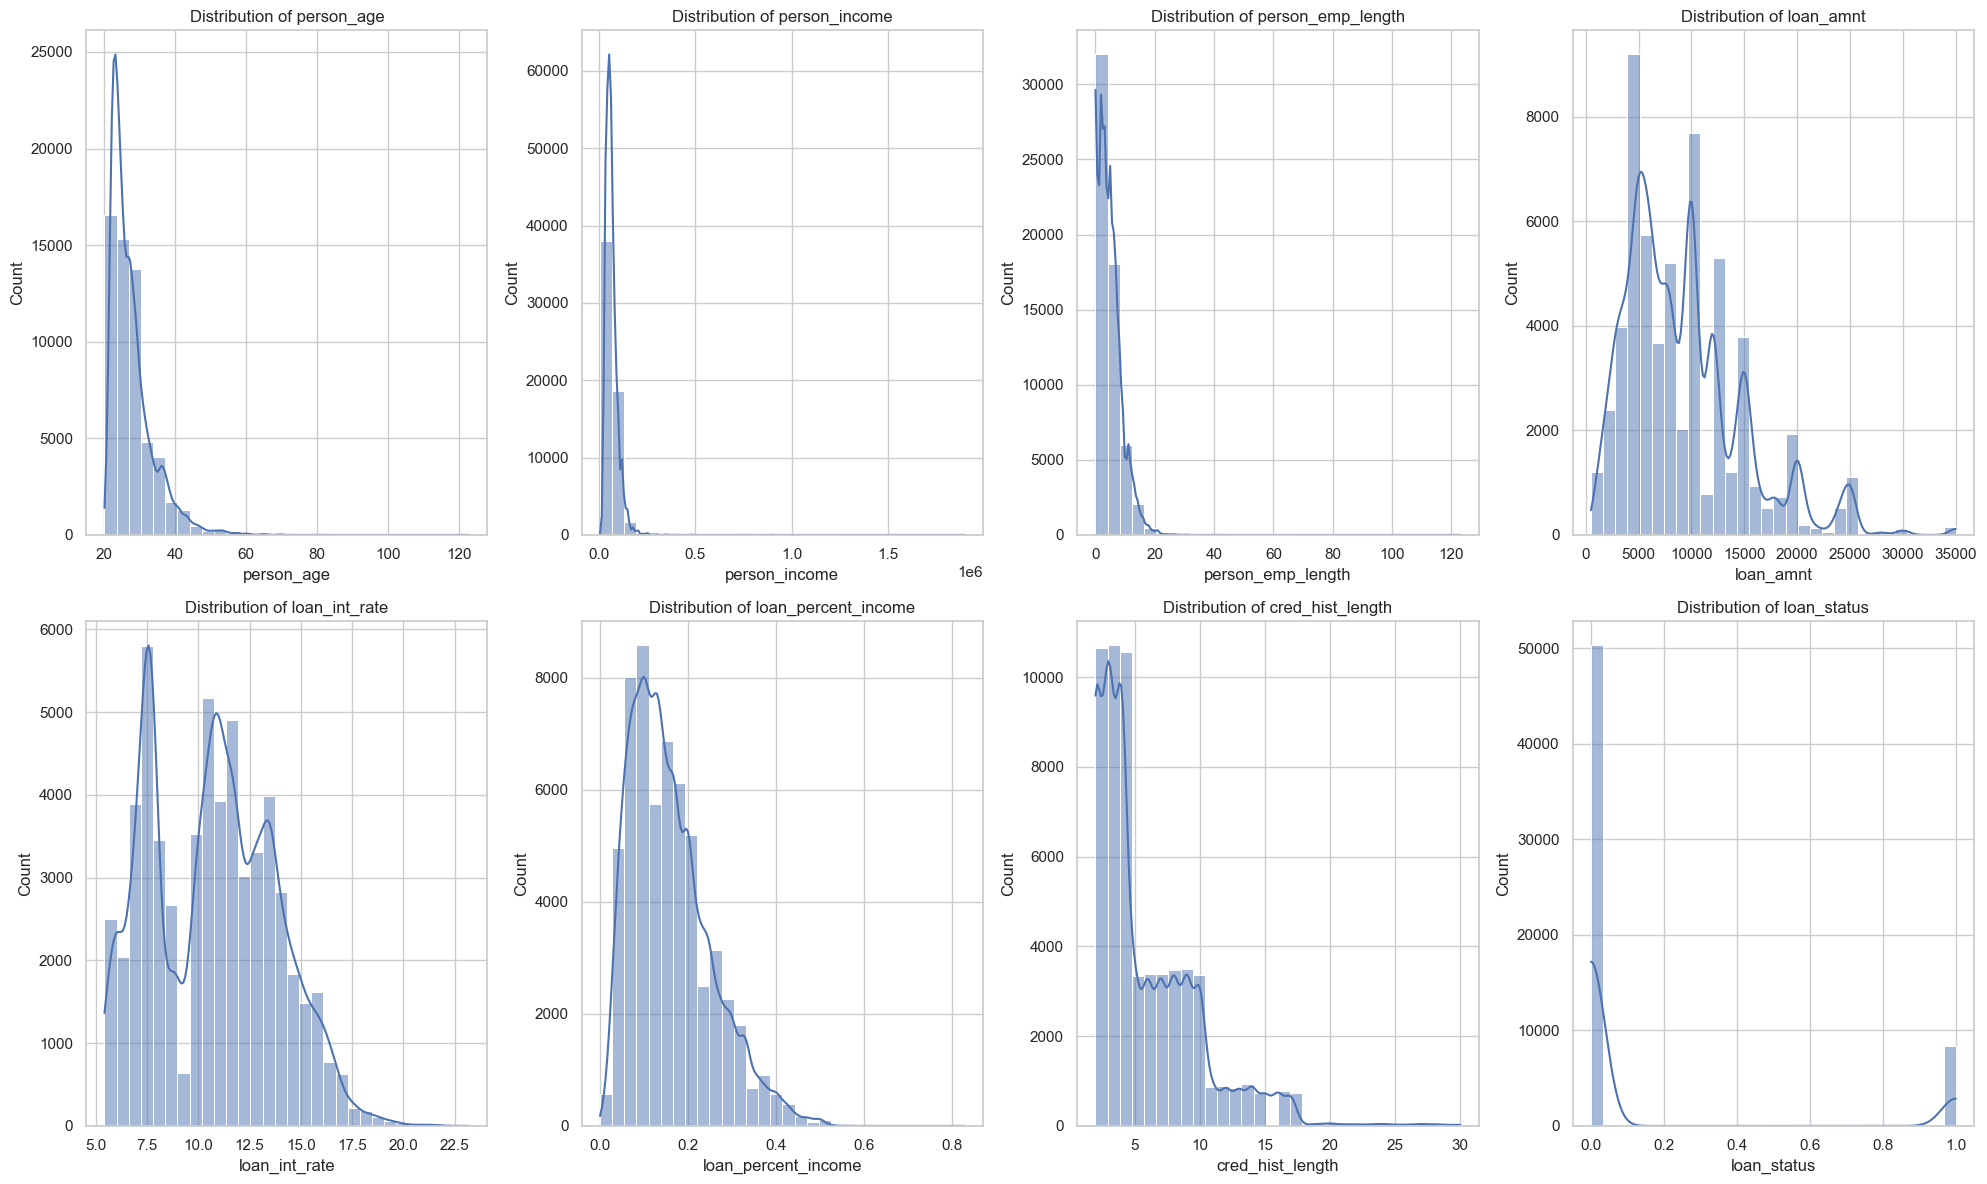

In [10]:
# Create a 2x3 grid for visualization
fig, ax = plt.subplots(2, 4, figsize=(20,12))

# Iterate over features and plot
for i, feature in enumerate(num_features):
    row, col = divmod(i, 4)
    sns.histplot(df[feature], kde=True, bins=30, ax=ax[row, col])
    ax[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

We can see that almost all of our variables are not normally distributed and mostly skewed right, so we'll use a log function to make these normal.

We won't apply a log function to loan_status, as this is our dependent variable.

In [11]:
df['log_age'] = np.log(df['person_age'])
df['log_income'] = np.log(df['person_income'])
df['log_emp'] = np.log(df['person_emp_length'])
df['log_loan_amnt'] = np.log(df['loan_amnt'])
df['log_loan_int_rate'] = np.log(df['loan_int_rate'])
df['log_loan_percent_income'] = np.log(df['loan_percent_income'])
df['log_cred_hist_length'] = np.log(df['cred_hist_length'])

log_features = {
    'log_age': df['log_age'],
    'log_income': df['log_income'],
    'log_emp': df['log_emp'],
    'log_loan_amnt': df['log_loan_amnt'],
    'log_loan_int_rate': df['log_loan_int_rate'],
    'log_loan_percent_income': df['log_loan_percent_income'],
    'log_cred_hist_length': df['log_cred_hist_length']
}

# Replacing log of 0 and negative numbers, dropping NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


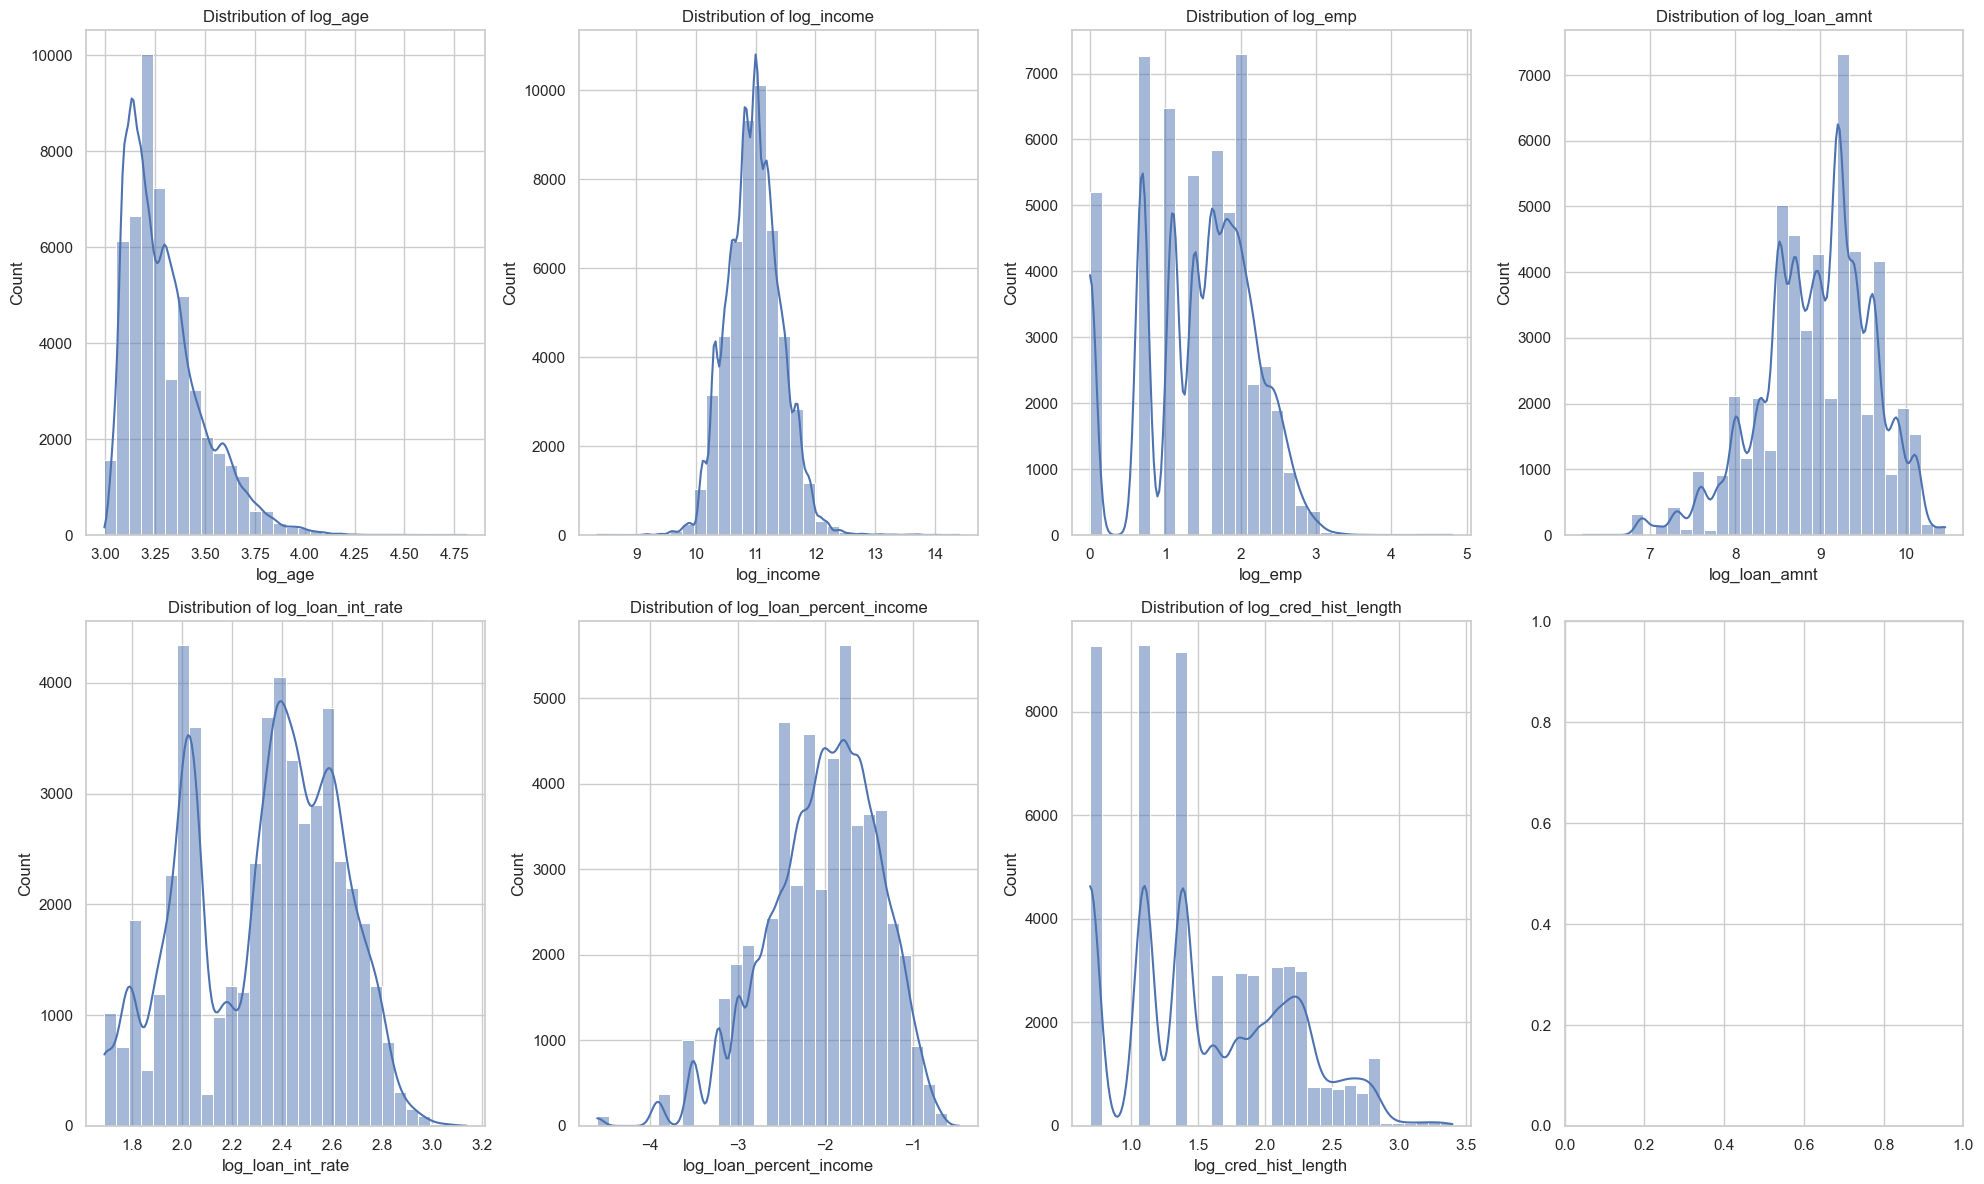

In [12]:
# Create a 2x3 grid for visualization
fig, ax = plt.subplots(2, 4, figsize=(20,12))

# Iterate over features and plot
for i, feature in enumerate(log_features):
    row, col = divmod(i, 4)
    sns.histplot(df[feature], kde=True, bins=30, ax=ax[row, col])
    ax[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

log generally helps with the distribution of our data, but some variables need to be further refined such as log_age, log_emp, log_loan_amnt, and log_cred_hist_length.

We'll standardize the features using z-scores to make this normally distributed.

In [13]:
# Using Z-Scores to remove outliers as this can standardized all values
z_scores = ['log_age', 'log_loan_amnt', 'log_loan_int_rate', 'log_loan_percent_income']

scaler = StandardScaler()
df[z_scores] = scaler.fit_transform(df[z_scores])

NameError: name 'StandardScaler' is not defined

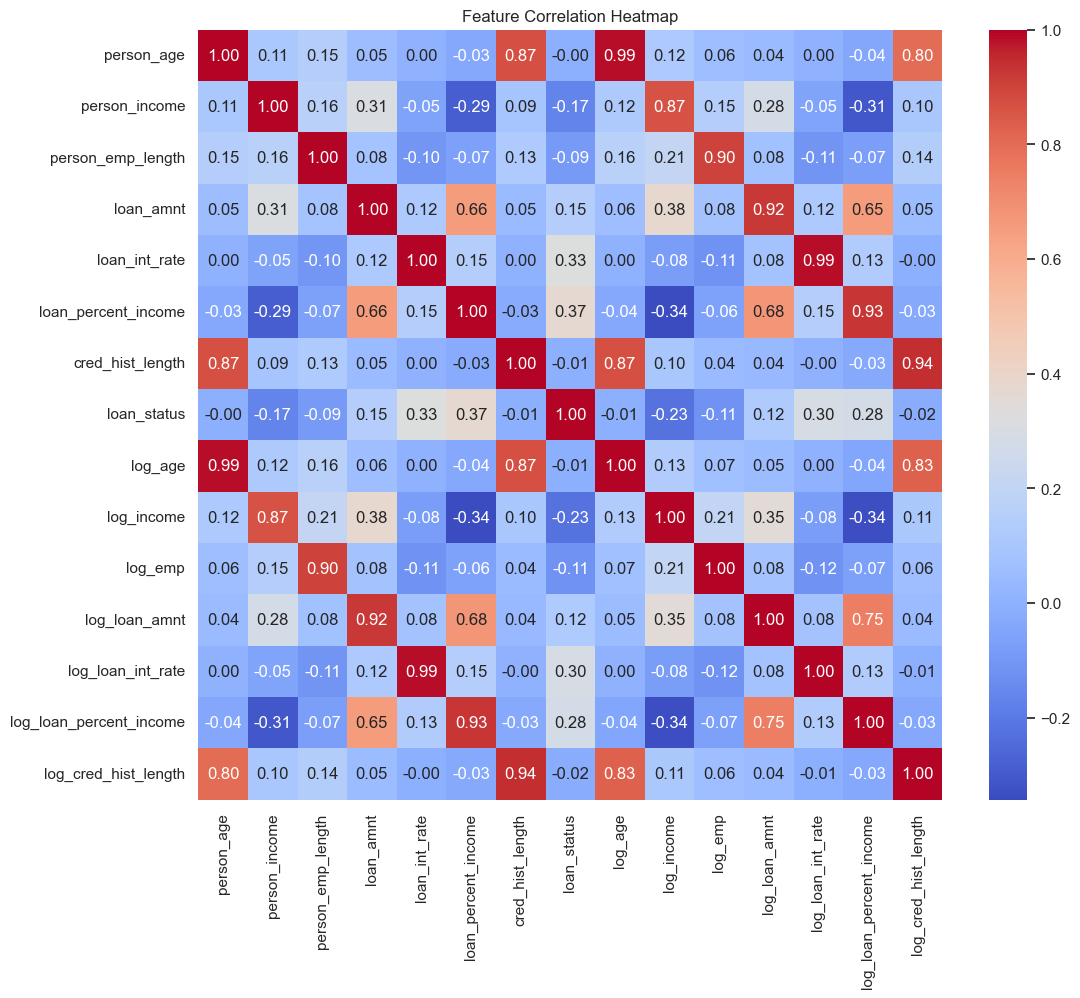

In [126]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_13577/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_13577/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
/var/folders/qx/cv2hhpx113lf4qvjz9pfffj80000gn/T/ipykernel_13577/1443147186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

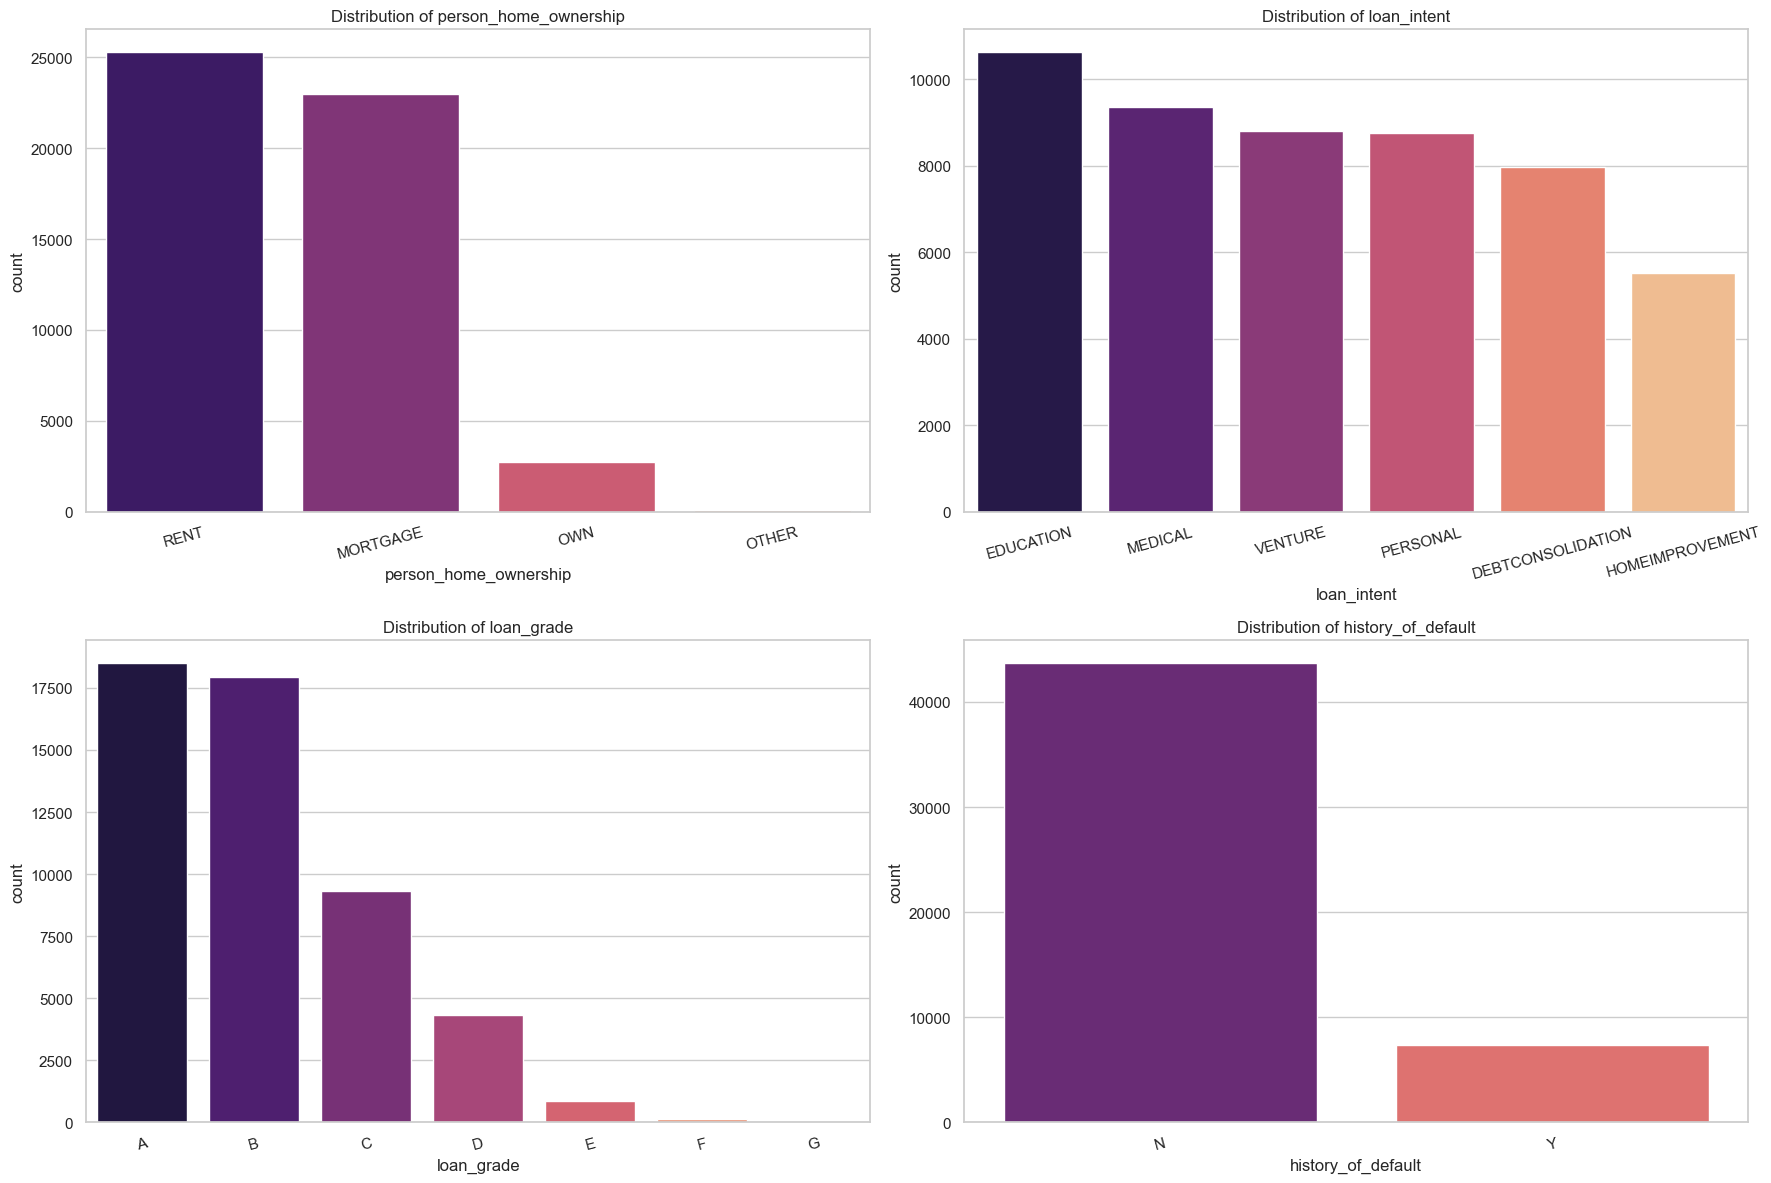

In [115]:
# Create 2x3 grid for visualization
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Iterate over categorical features and plot
for i, feature in enumerate(cat_features):
    row, col = divmod(i, 2)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax[row, col], palette='magma')
    ax[row, col].set_title(f'Distribution of {feature}')
    ax[row, col].tick_params(axis='x', rotation=15)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

We can see that person_age and cred_hist_length have a high correlation between one another, so we'll look into dropping one of these variables.

loan_amnt and loan_percent_income also have a moderate correlation, so we'll look into these features.

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

log_features_list = [
    'log_age', 'log_income', 'log_emp',
    'log_loan_amnt', 'log_loan_int_rate',
    'log_loan_percent_income', 'log_cred_hist_length'
]

X = df[log_features_list]
y = df['loan_status']

# Replacing infs with NaNs
X = X.replace([np.inf, -np.inf], np.nan)

# Dropping NaN values
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression Accuracy: 0.8854941898420159


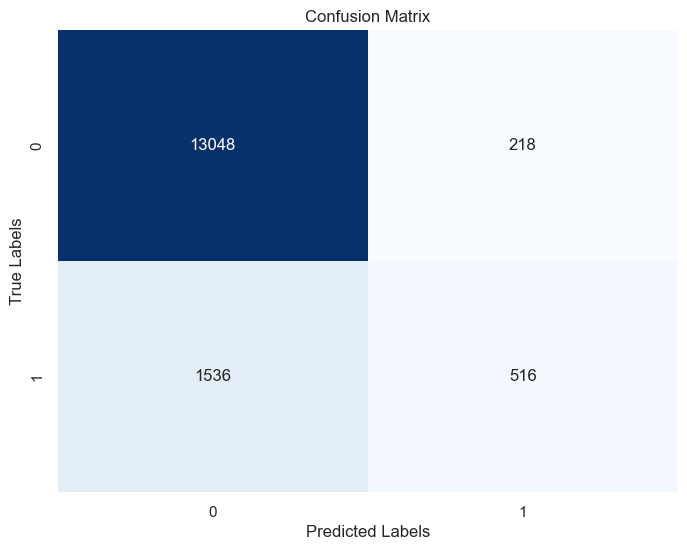

Precision: 0.7029972752043597
Recall: 0.25146198830409355
F1-Score: 0.3704235463029433


In [58]:
# Logistic Regression for Classification
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", acc_log)

cm1 =  confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
##roc_auc = roc_auc_score(y_class_test, y_prob_class)  # Typically y_prob_class[:,1] if using predict_proba

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
#print("ROC-AUC:", roc_auc)

In [57]:
target_cols = ['loan_status']
features = [col for col in df.columns if col not in target_cols]

# Already converted all my categorical variables into numerical, making sure all numerical features are captured
num_features = [col for col in features if df[col].dtype != "object"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features) # Numeric features being processed; scales num features while reducing effect of outliers using median and IQR
    ],
    sparse_threshold=0
)

X_processed = preprocessor.fit_transform(df[features])

df_transformed = pd.DataFrame(X_processed, columns=num_features)
print(df_transformed.head()) # All numerical features scaled to a consistent range

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [56]:
df.describe(include='all')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,log_age,log_income,log_emp,log_loan_amnt,log_loan_int_rate,log_loan_percent_income,log_cred_hist_length
count,58645.000000,5.864500e+04,58645,58645.000000,58645,58645,58645.000000,58645.000000,58645.000000,58645,58645.000000,58645.000000,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,5.864500e+04,58645.000000
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,30594,NaN,12271,20984,NaN,NaN,NaN,49943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,27.550857,6.404617e+04,NaN,4.701015,NaN,NaN,9217.556518,10.677874,0.159238,NaN,5.813556,0.142382,3.295965,10.957107,-inf,8.941512,2.325661,-inf,1.554229
std,6.033216,3.793111e+04,NaN,3.959784,NaN,NaN,5563.807384,3.034697,0.091692,NaN,4.029196,0.349445,0.192741,0.456861,NaN,0.642189,0.296642,NaN,0.631052
min,20.000000,4.200000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,NaN,2.000000,0.000000,2.995732,8.342840,-inf,6.214608,1.690096,-inf,0.693147
25%,23.000000,4.200000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.880000,0.090000,NaN,3.000000,0.000000,3.135494,10.645425,6.931472e-01,8.517193,2.064328,-2.407946e+00,1.098612
50%,26.000000,5.800000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.750000,0.140000,NaN,4.000000,0.000000,3.258097,10.968198,1.386294e+00,8.987197,2.374906,-1.966113e+00,1.386294
75%,30.000000,7.560000e+04,NaN,7.000000,NaN,NaN,12000.000000,12.990000,0.210000,NaN,8.000000,0.000000,3.401197,11.233212,1.945910e+00,9.392662,2.564180,-1.560648e+00,2.079442


<ul>
<li>Now with person_age, person_emp_length, and person_income normalized, the summary statistics for these values are much more closer together for EDA.</li><br>
<li>More than half of the people applying for loans rent their houses.</li><br>
<li>Most people also apply for a loan due to education. Judging from how small the age range is (at a mean of about 26-27 years old), this could likely be loans for higher education/to pay tuition.</li><br>
<li>Most people applying for loans aren't employeed at their job for long with a mean of 4 years.</li><br>
<li>The interest rates for loans have a mean of about 10%.</li><br>
<li>The percentage of the loan amount as part of a person's income is fairly low at a mean of 14-16%, with an average loan amount of $9000.</li><br>
<li>cred_hist_length and person_emp_length are very similar in numbers, so we can look into these variables to see if they measure the same thing.</li><br>

Individuals applying for a loan mostly rent/mortgage their home; use it for education or medical; have high loan grades; and do not have a history of default.

<h3>Bivariate Analysis</h3>

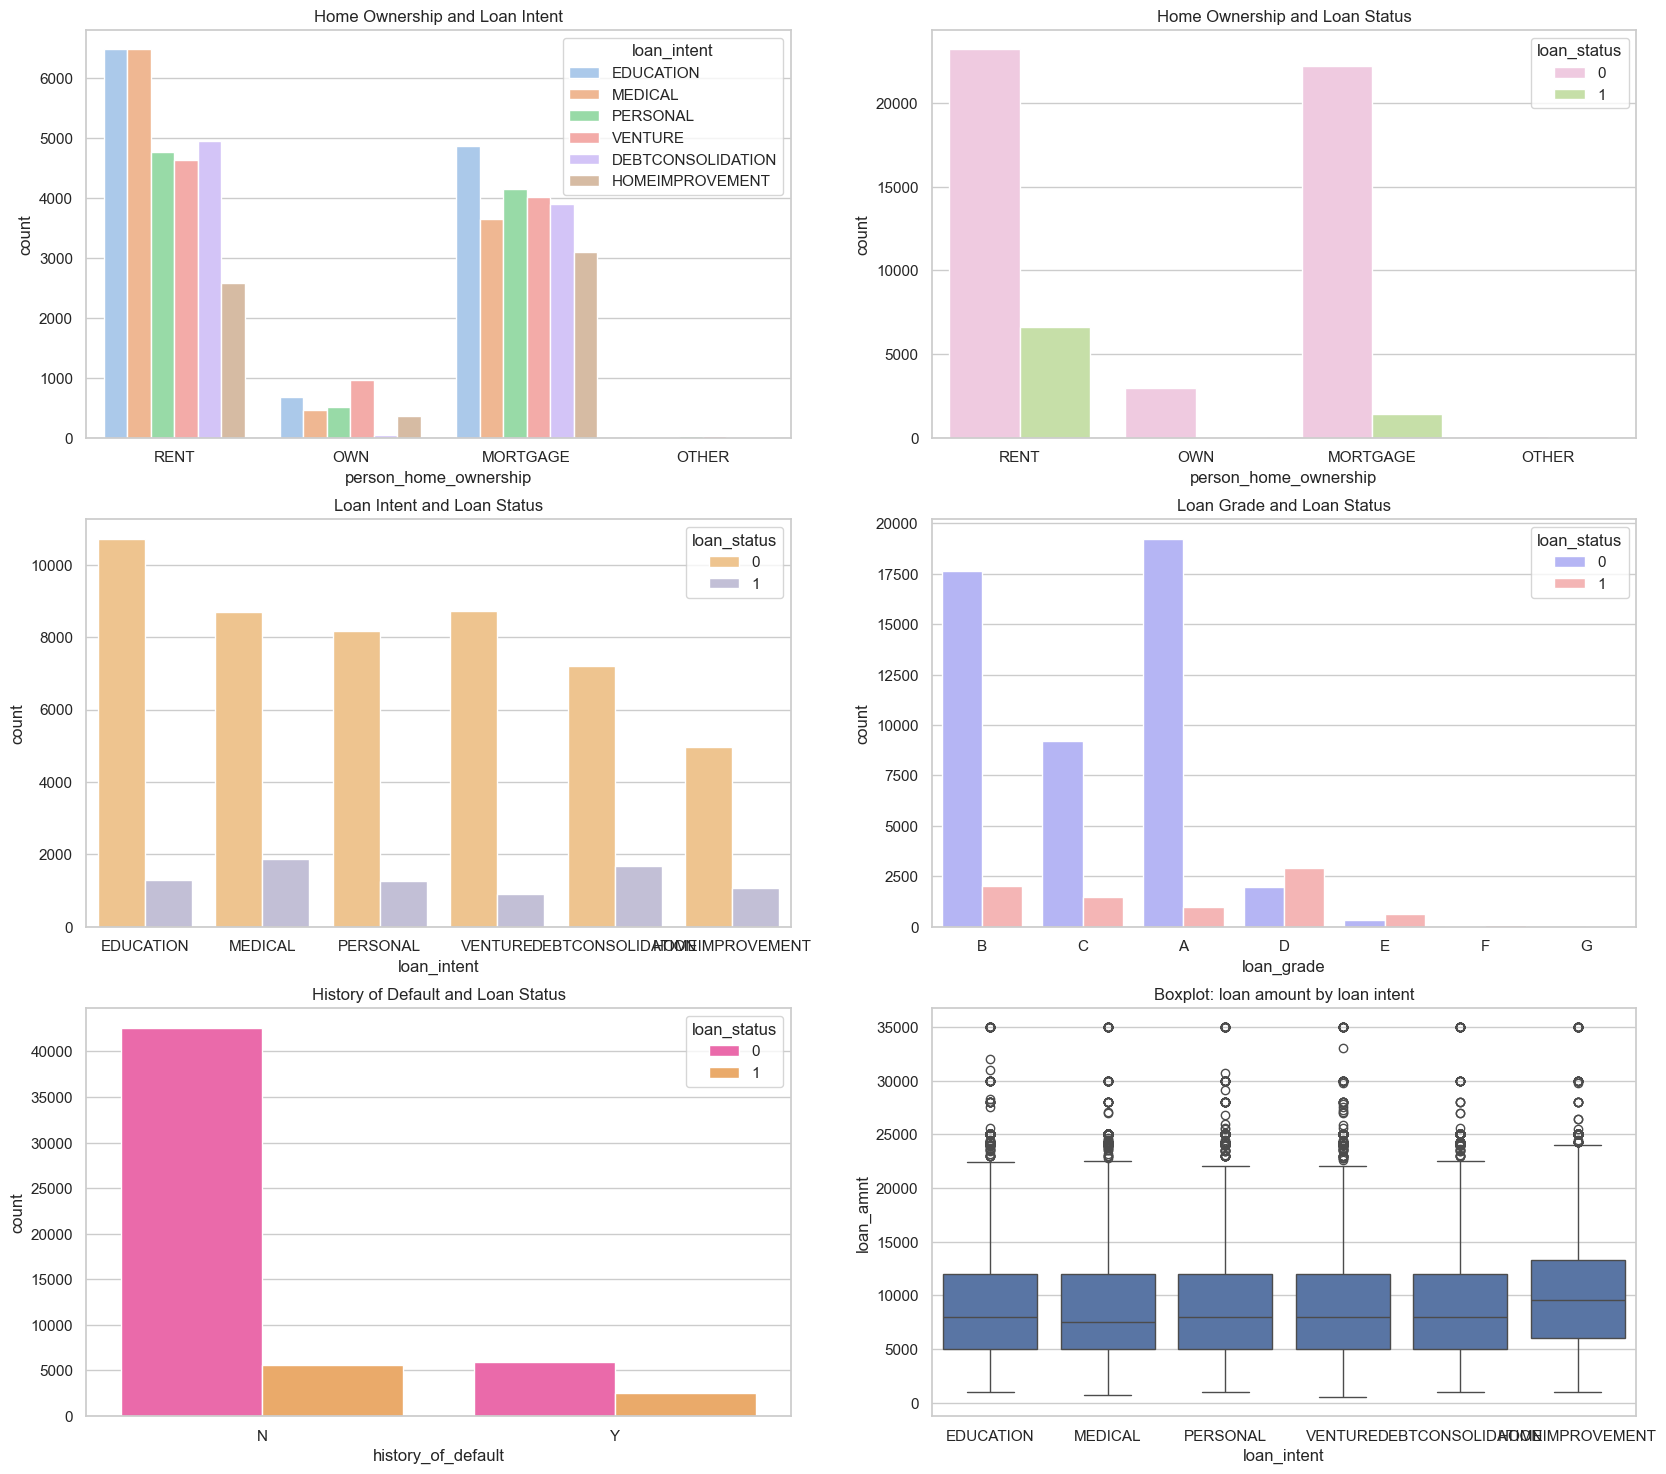

In [27]:
# Grouped bar plot for categorical vs. categorical
# Also playing around with palettes lol

fig, ax = plt.subplots(3, 2, figsize=(20, 18))

# Home Ownership and Loan Intent
sns.countplot(data=df, x='person_home_ownership', hue='loan_intent', palette='pastel', ax=ax[0,0])
ax[0,0].set_title("Home Ownership and Loan Intent")

# Home Ownership and Loan Status
sns.countplot(data=df, x='person_home_ownership', hue='loan_status', palette='PiYG', ax=ax[0,1])
ax[0,1].set_title("Home Ownership and Loan Status")

# Loan Intent and Loan Status
sns.countplot(data=df, x='loan_intent', hue='loan_status', palette='PuOr', ax=ax[1,0])
ax[1,0].set_title("Loan Intent and Loan Status")

# Loan Grade and Loan Status
sns.countplot(data=df, x='loan_grade', hue='loan_status', palette='bwr', ax=ax[1,1])
ax[1,1].set_title("Loan Grade and Loan Status")

# History of Default and Loan Status
sns.countplot(data=df, x='history_of_default', hue='loan_status', palette='spring', ax=ax[2,0])
ax[2,0].set_title("History of Default and Loan Status")

# Box plot for numerical vs. categorical
sns.boxplot(data=df, x='loan_intent', y='loan_amnt')
plt.title("Boxplot: loan amount by loan intent")
plt.show()

A lot of people who rent their homes apply for loans with a educational or medical intent. Similarly with those who mortgage their homes, but mostly apply with the intent for education and personal.

Those who rent have have a higher approval for a loan than those who mortgage, while those who own did not get approved for a loan.

Those with a medical intent appear to be approved for a loan more, however, a percentage would probably be best to determine who gets approved more (out of all intents).

Lower loan grade status (high risk) tends to get approved for a loan more, compared to high grade. This is probably because lower grades have higher interest rates.

It looks like the proportion between those with a default history and loan approval is probably higher than those without a default history and loan approval. This proportion is probably higher because those with previous default history are offered higher interest rates.

The loan amount mean and outliers across all loan intents seems to be fairly similar. 

<h3>Multivariate Analysis</h3>

In [28]:
# Converting categorical variables into numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
loan_grade_label = le.fit_transform(df['loan_grade']) # I think only loan_grade is the best for label encoder as it is ordinal
# This made loan grade start at 0, but it would be easier to understand for loan_grade if A is 1, B is 2, etc.
df['loan_grade'] = loan_grade_label + 1

df['person_home_ownership'] = df['person_home_ownership'].map(
    {"RENT": 1, "OWN": 2, "MORTGAGE": 3, "OTHER": 4})

df['loan_intent'] = df['loan_intent'].map(
    {"EDUCATION": 1, "MEDICAL": 2, "PERSONAL": 3, "VENTURE": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6})

df['history_of_default'] = df['history_of_default'].map(
    {"N": 0, "Y": 1})

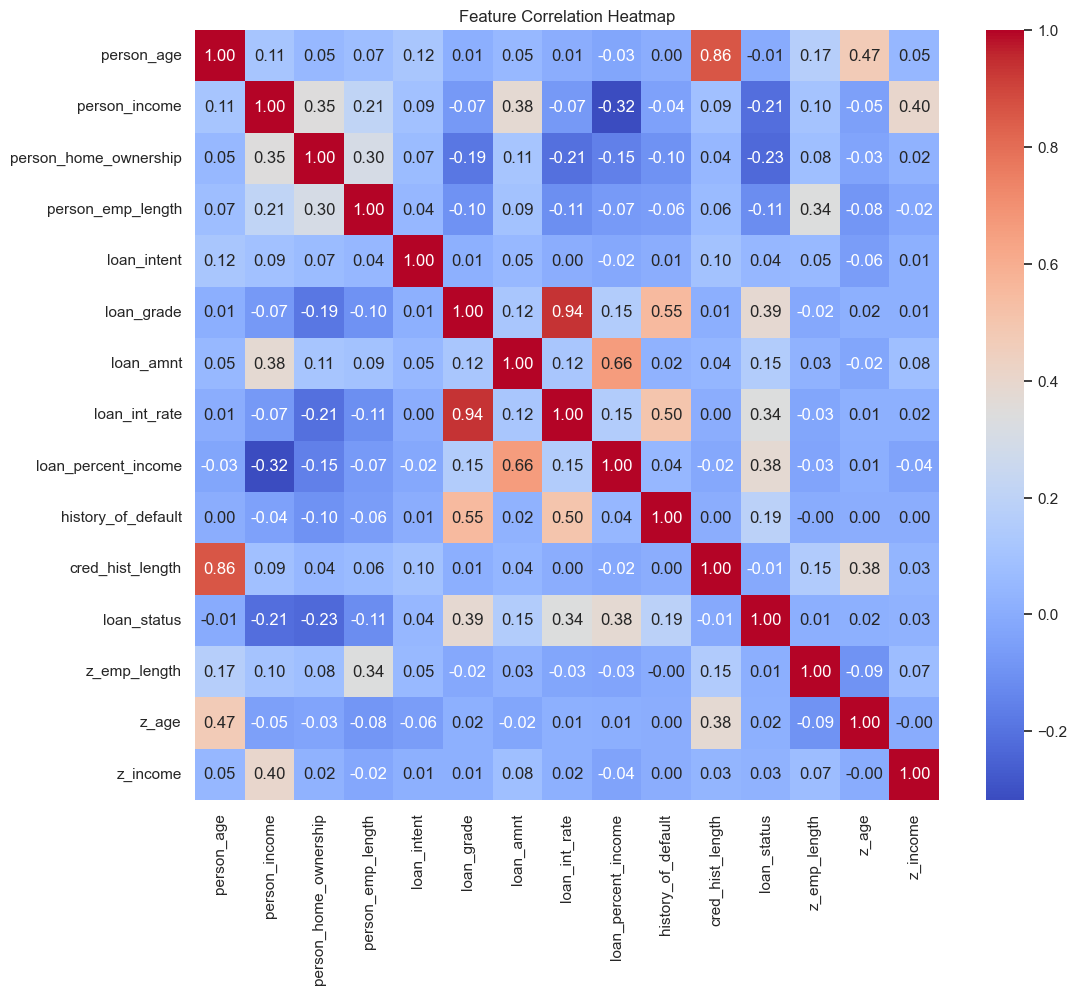

In [29]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Features to look into for loan_status:

Positive correlation:
<li>loan_grade (0.39)</li>
<li>loan_percent_income (0.38)</li>
<li>loan_int_rate (0.34)</li>
<li>history_of_default (0.19)</li>
<li>loan_amnt (0.15)</li>

Negative correlation:
<li>person_home_ownership (-0.23)</li>
<li>person_income (-0.21)</li>
<li>person_emp_length (-0.11)</li>

Other important insights about the predictors:

<li>person_age and cred_hist_length have a high correlation to each other. We can look into these predictors a bit more (maybe using VIF) to see if there is multicollinearity.</li><br>
<li>loan_grade and history_of_default have a moderate correlation of 0.55 to each other. Since loan_grade is encoded as A = 1, B = 2, etc., this means that the lower the loan_grade (D = 4, E = 5, F = 6), the higher the person has a history of defaulting. We can look into this more for loan_status since loan_grade and loan_status have a weak-moderate correlation.</li><br>
<li>loan_grade and loan_int_rate have a very strong correlation to each other. This means that the lower the loan_grade (D = 4, E = 5, etc.), the higher the interest rate for the loan. This is because a high-risk loans will have a higher interest rate.</li><br>

<h3>Summary</h3>

Overall, we have a decent amount of data to determine whether a loan is likely to be paid back. Some of the factors that we can look into that may influence the likelihood include:

<li>loan_grade</li>
<li>loan_percent_income</li>
<li>loan_int_rate</li>
<li>history_of_default</li>
<li>loan_amnt</li>
<li>person_home_ownership</li>
<li>person_income</li>
<li>person_emp_length</li>

This standardizes all the variables to the same scale to have a mean of 0 and a standard deviation of 1.

This allows us to measure everything similarly to avoid bias; for example, we'll be able to compare person_age with person_income with standardization.

In [57]:
# Split features and targets
X = df_transformed

# Class we are testing
y = df['loan_status'].astype(int)  # Ensure binary target is integer (0/1)

# Split into training and test sets (70/30 split)
# we are using the same training set but distinct targets for the classification & regression models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y) # Prevents class imbalance

# Could probably use test.csv data to train model

<h3>Logistic Regression</h3>

<h3>Log Odds for Logistic Regression</h3>

In [36]:
log_odds = log_reg.coef_  # This returns a 2D array (for binary classification, shape is (1, n_features))
log_odds_series = pd.Series(log_odds[0], index=X_train.columns)
print("Logistic Regression Log Odds:")
print(log_odds_series.sort_values(ascending=False))

# The sign and magnitude of each log-odds coefficient indicate how a one-unit
# change in the feature affects the log odds of being in the positive class

Logistic Regression Log Odds:
loan_grade               2.296154
loan_percent_income      1.303282
loan_intent              0.393351
z_emp_length             0.196204
z_income                 0.134441
z_age                    0.057693
person_age               0.026071
cred_hist_length        -0.080654
loan_amnt               -0.119986
loan_int_rate           -0.125244
person_emp_length       -0.176244
history_of_default      -0.177731
person_income           -0.410173
person_home_ownership   -1.074333
dtype: float64


<h3>Decision Tree</h3>

In [37]:
# Might have to do this with person_income instead of log_person_income
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=50,max_depth=5)
dt_clf.fit(X_train, y_train)
y_pred_dt_clf = dt_clf.predict(X_test)
acc_dt_clf = accuracy_score(y_test, y_pred_dt_clf)
print("Decision Tree Classifier Accuracy:", acc_dt_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt_clf))

Decision Tree Classifier Accuracy: 0.9417933309767881
Confusion Matrix:
 [[14470    76]
 [  912  1516]]


<h3>Decision Tree Visualization</h3>

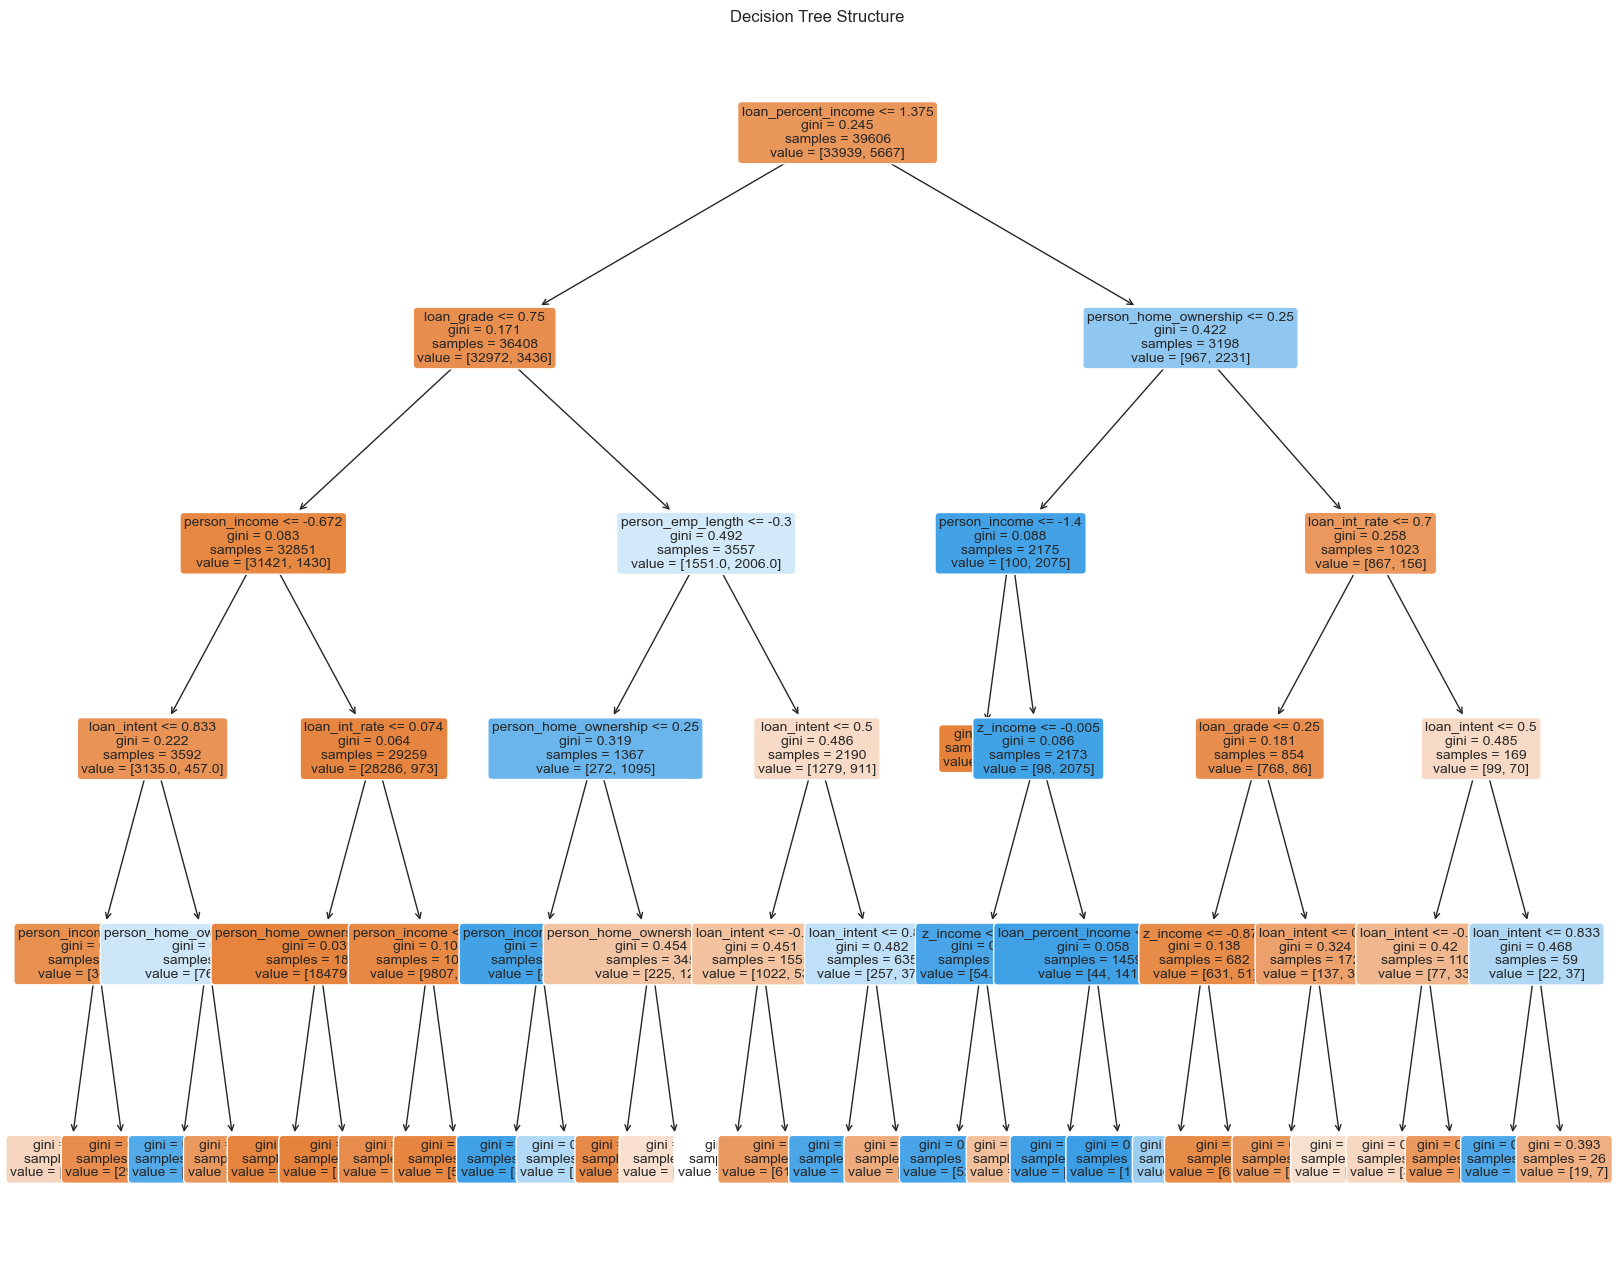

In [38]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 16))
plot_tree(dt_clf, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

<h3>Random Forest Classifier</h3>

In [39]:
# Might have to do this with person_income instead of log_person_income
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf_clf = rf_clf.predict(X_test)
acc_rf_clf = accuracy_score(y_test, y_pred_rf_clf)
print("Random Forest Classifier Accuracy:", acc_rf_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_clf))

Random Forest Classifier Accuracy: 0.9496877577471426
Confusion Matrix:
 [[14397   149]
 [  705  1723]]


<h3>KNeighbors Classifier</h3>

In [53]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
print(neigh.predict(X_test)) # Prints out the loan_status values for the test data. We can use this to compare with the actual data

[0 0 1 ... 0 0 0]


In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train1 = scaler.transform(X_train)
X_test1 = scaler.transform(X_test)

<h3>Linear SVC</h3>

<h3>Naive Bayes</h3>